### Import dataset

In [1]:
import pandas as pd
df = pd.read_csv('covid_19_indonesia_time_series_all.csv')
pd.set_option('display.max_columns', None)
df.head()

,Date,Location ISO Code,Location,New Cases,New Deaths,New Recovered,New Active Cases,Total Cases,Total Deaths,Total Recovered,Total Active Cases,Location Level,City or Regency,Province,Country,Continent,Island,Time Zone,Special Status,Total Regencies,Total Cities,Total Districts,Total Urban Villages,Total Rural Villages,Area (km2),Population,Population Density,Longitude,Latitude,New Cases per Million,Total Cases per Million,New Deaths per Million,Total Deaths per Million,Total Deaths per 100rb,Case Fatality Rate,Case Recovered Rate,Growth Factor of New Cases,Growth Factor of New Deaths
0,3/1/2020,ID-JK,DKI Jakarta,2,0,0,2,39,20,75,-56,Province,NaN,DKI Jakarta,Indonesia,Asia,Jawa,UTC+07:00,Daerah Khusus Ibu Kota,1,5.0,44,267.0,NaN,664,10846145,16334.31,106.836118,-6.204699,0.18,3.60,0.0,1.84,0.18,51.28%,192.31%,NaN,NaN
1,3/2/2020,ID-JK,DKI Jakarta,2,0,0,2,41,20,75,-54,Province,NaN,DKI Jakarta,Indonesia,Asia,Jawa,UTC+07:00,Daerah Khusus Ibu Kota,1,5.0,44,267.0,NaN,664,10846145,16334.31,106.836118,-6.204699,0.18,3.78,0.0,1.84,0.18,48.78%,182.93%,1.0,1.0
2,3/2/2020,IDN,Indonesia,2,0,0,2,2,0,0,2,Country,NaN,NaN,Indonesia,Asia,NaN,NaN,NaN,416,98.0,7230,8488.0,74953.0,1916907,265185520,138.34,113.921327,-0.789275,0.01,0.01,0.0,0.00,0.00,0.00%,0.00%,NaN,NaN
3,3/2/2020,ID-RI,Riau,1,0,0,1,1,0,1,0,Province,NaN,Riau,Indonesia,Asia,Sumatera,UTC+07:00,NaN,10,2.0,169,268.0,1591.0,87024,6074100,69.80,101.805109,0.511648,0.16,0.16,0.0,0.00,0.00,0.00%,100.00%,NaN,NaN
4,3/3/2020,ID-JK,DKI Jakarta,2,0,0,2,43,20,75,-52,Province,NaN,DKI Jakarta,Indonesia,Asia,Jawa,UTC+07:00,Daerah Khusus Ibu Kota,1,5.0,44,267.0,NaN,664,10846145,16334.31,106.836118,-6.204699,0.18,3.96,0.0,1.84,0.18,46.51%,174.42%,1.0,1.0


### Drop semua kolom yang bukan numerik
### Kemudian drop kolom yang dianggap tidak memengaruhi prediksi

In [2]:
df = df.select_dtypes(include=['number'])
df.drop(df.columns[4:], axis=1, inplace=True)
df.isna().sum()

New Cases           0
New Deaths          0
New Recovered       0
New Active Cases    0
dtype: int64

### Split dataset menjadi data train dan data test
### Kasus yang dipilih adalah memprediksi nilai dari New Deaths berdasarkan New Cases, New Recovered, dan Active Cases
### Fitur = New Cases, New Recovered, dan Active Cases
### Target = New Deaths

In [3]:
from sklearn.model_selection import train_test_split

X = df.drop(['New Deaths'], axis=1)
y = df['New Deaths']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Membuat model dengan 5 layer
### Menggunakan activation relu dengan 3 input
### Menggunakan 1 output layer karena target hanya 1 dan menggunakan default activation yaitu linear

In [4]:
import tensorflow as tf

model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(3,)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1) # Output layer untuk regresi dengan 1 neuron (linear)
])

### Membuat fungsi r2_score untuk metrics model, karena tidak ada fungsi default untuk metrics r2_score

In [5]:
from tensorflow.keras import backend as K

def r2_score(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return (1 - SS_res/(SS_tot + K.epsilon()))

### Compile model dengan optimizer Adam dan loss huber karena huber dapat mengabaikan data outlier, serta menggunakan metrics r2_score yang telah dibuat di atas

In [6]:
model.compile(optimizer='Adam', loss='huber', metrics=[r2_score])

### Membuat callback untuk memonitoring val_loss
### Menggunakan library ModelCheckpoint untuk menyimpan hasil terbaik selama pelatihan
### Misalkan val_loss tidak menurun atau tidak membaik

In [8]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Model checkpoint untuk menyimpan model terbaik selama pelatihan (dengan val_loss terendah)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, verbose=1)

### Train data dengan jumlah epochs 500 dan juga menggunakan callback yang telah dibuat di atas

In [14]:
trained_data = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=500, callbacks=model_checkpoint)

Epoch 1/500
776/796 [============================>.] - ETA: 0s - loss: 8.5463 - r2_score: -4.0348
Epoch 1: val_loss improved from inf to 7.29478, saving model to best_model.h5
796/796 [==============================] - 3s 3ms/step - loss: 8.4815 - r2_score: -3.9938 - val_loss: 7.2948 - val_r2_score: 0.3726
Epoch 2/500
 49/796 [>.............................] - ETA: 1s - loss: 9.1782 - r2_score: -0.7245

C:\Kuliah\Semester5\Praktikum\KecerdasanBuatan\venv_jupyterlab\Anhar\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


782/796 [============================>.] - ETA: 0s - loss: 6.9753 - r2_score: -1.2788
Epoch 2: val_loss did not improve from 7.29478
796/796 [==============================] - 2s 2ms/step - loss: 6.9893 - r2_score: -1.3193 - val_loss: 7.3180 - val_r2_score: -1.0464
Epoch 3/500
783/796 [============================>.] - ETA: 0s - loss: 6.5914 - r2_score: -1.1190
Epoch 3: val_loss did not improve from 7.29478
796/796 [==============================] - 2s 2ms/step - loss: 6.7332 - r2_score: -3.8260 - val_loss: 16.4505 - val_r2_score: -43.8876
Epoch 4/500
790/796 [============================>.] - ETA: 0s - loss: 6.2535 - r2_score: -1.1541
Epoch 4: val_loss improved from 7.29478 to 7.06500, saving model to best_model.h5
796/796 [==============================] - 2s 2ms/step - loss: 6.3055 - r2_score: -1.1552 - val_loss: 7.0650 - val_r2_score: -0.0936
Epoch 5/500
784/796 [============================>.] - ETA: 0s - loss: 6.2288 - r2_score: -0.7462
Epoch 5: val_loss improved from 7.06500 to 

### prediksi model menggunakan fitur

In [15]:
y_pred = model.predict(X_test)
y_pred

199/199 [==============================] - 0s 1ms/step


array([[ 3.7828953e+00],
       [-1.8696511e-02],
       [ 1.0730246e+00],
       ...,
       [-1.8696511e-02],
       [ 2.1199629e+02],
       [ 1.9045944e+00]], dtype=float32)

### Evaluasi model menggunakan fungsi r2_score
### Dapat dilihat hasil evaluasi dengan r2_score dibawah menunjukkan angka yang sangat baik, yaitu 0.9980

In [16]:
from sklearn.metrics import r2_score

r2 = r2_score(y_test, y_pred)
print(f"R2 Score: {r2:.4f}")

R2 Score: 0.9980


### Evaluasi mode menggunakan fungsi evaluate
### Dapat dilihat angka loss sangat rendah yaitu 0.3844 dan r2_score 0.9808 yang berarti model dapat menjelaskan kurang lebih 98% dari data

In [17]:
eval_result = model.evaluate(X_test, y_test)

199/199 [==============================] - 0s 1ms/step - loss: 0.3844 - r2_score: 0.9808


### Membuat grafik yang menunjukkan perkembangan model
### Grafik ini menjukkan perkembangan metrics r2_score dengan jumlah epochs

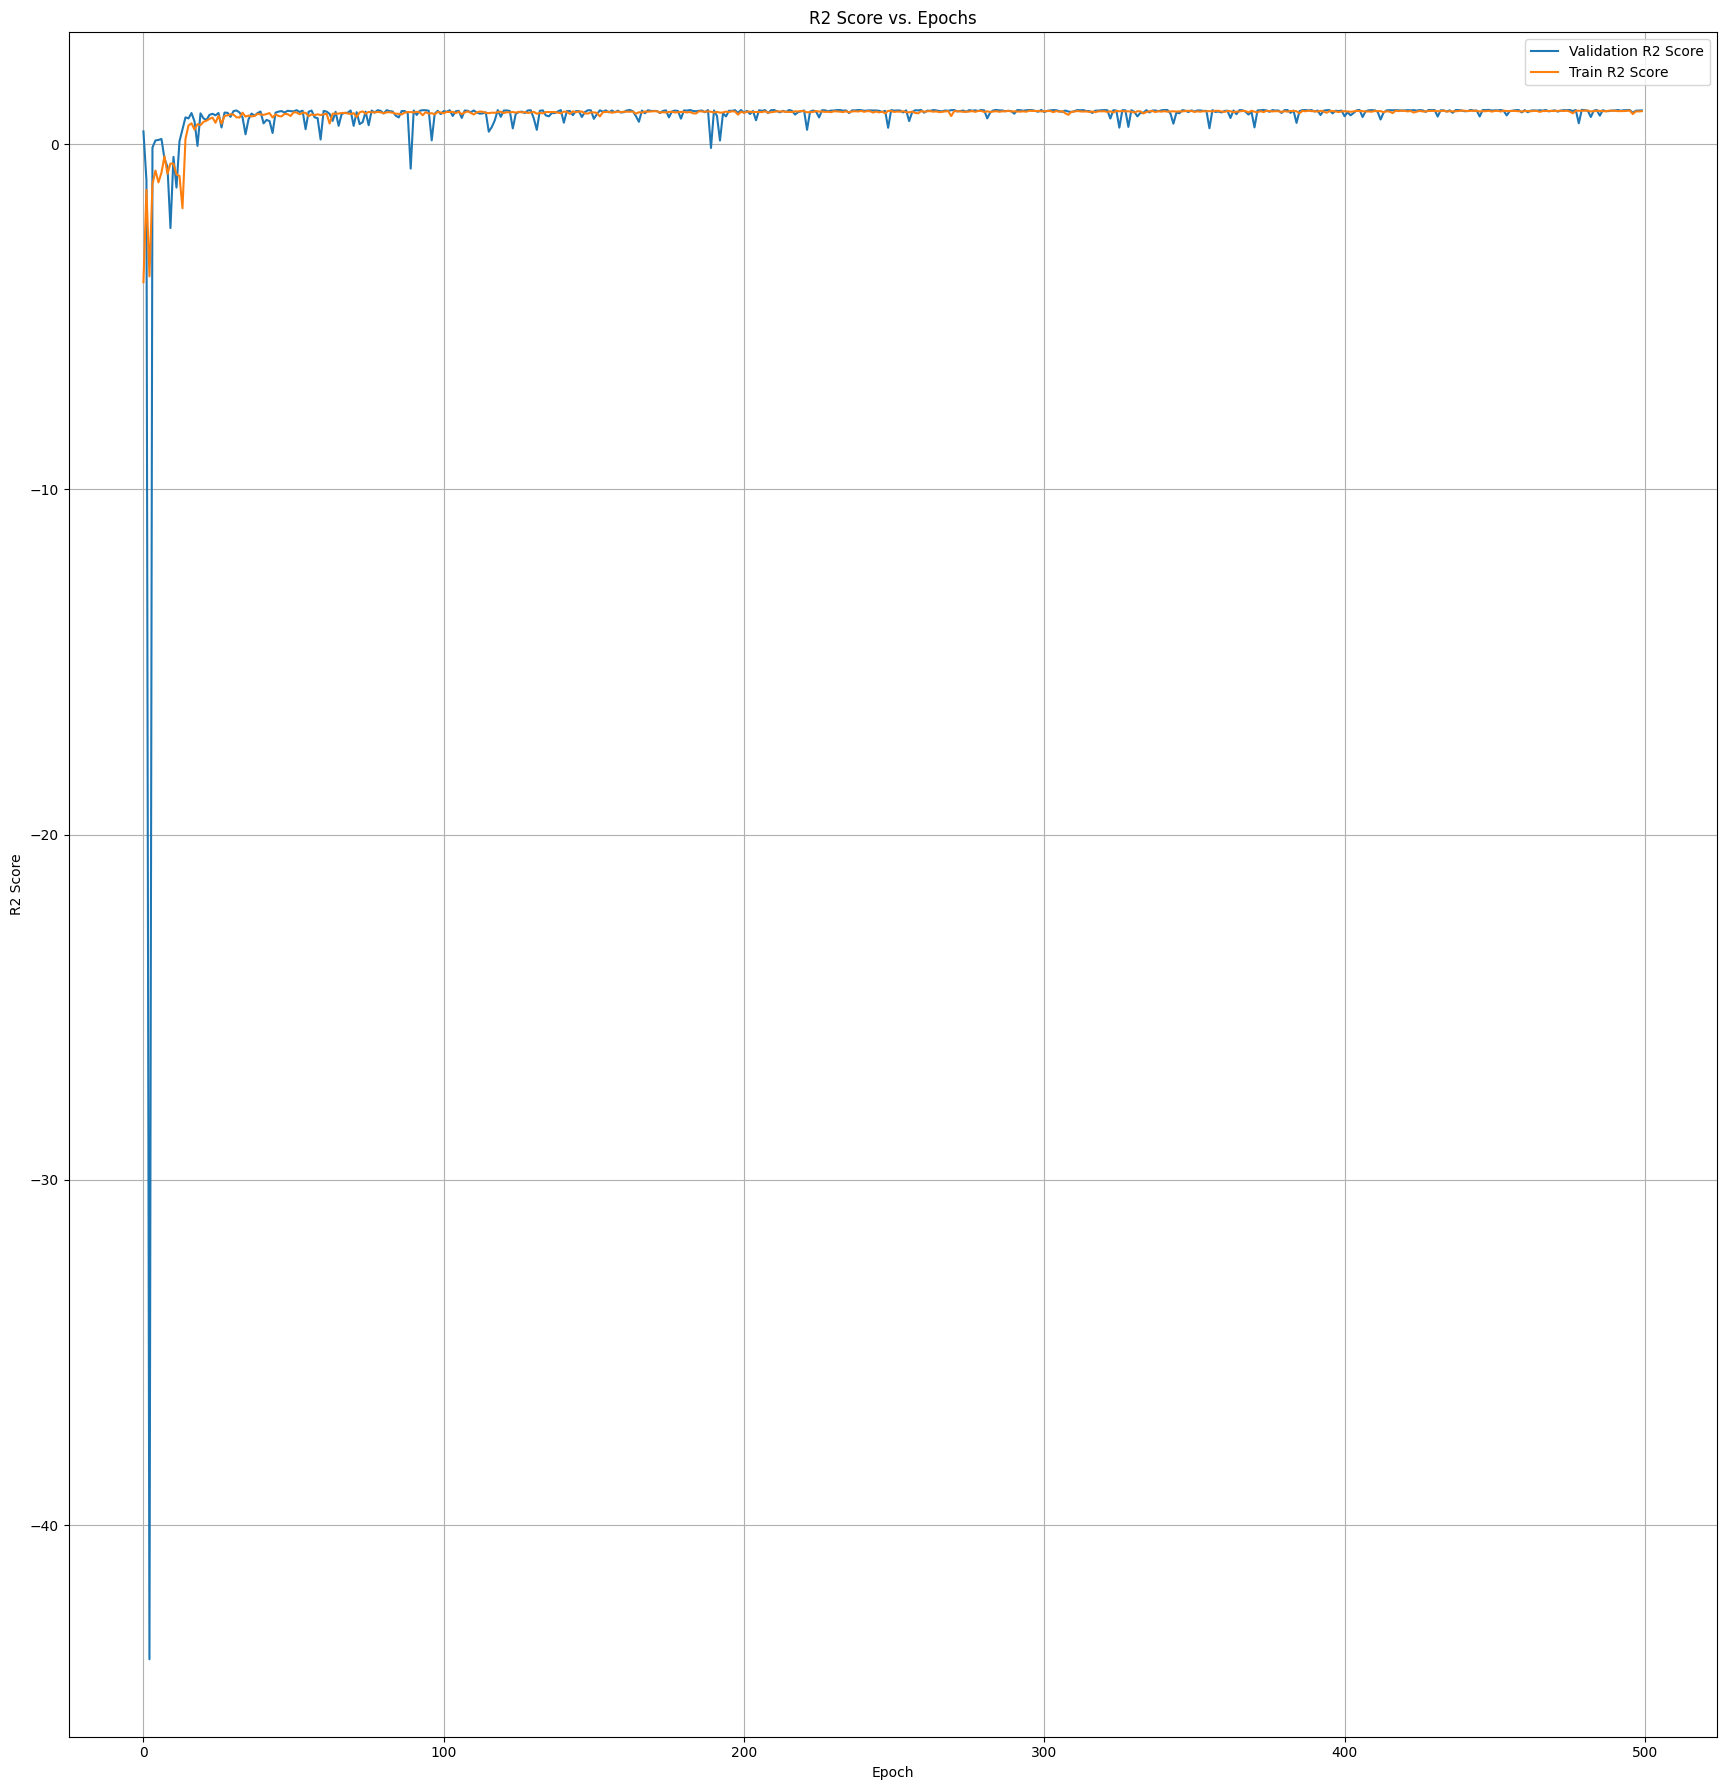

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(34, 18))
plt.subplot(1, 2, 1)
plt.plot(trained_data.history['val_r2_score'], label='Validation R2 Score')
plt.plot(trained_data.history['r2_score'], label='Train R2 Score')
plt.title('R2 Score vs. Epochs')
plt.ylabel('R2 Score')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Grafik ini menjukkan perkembangan train loss dengan jumlah epochs

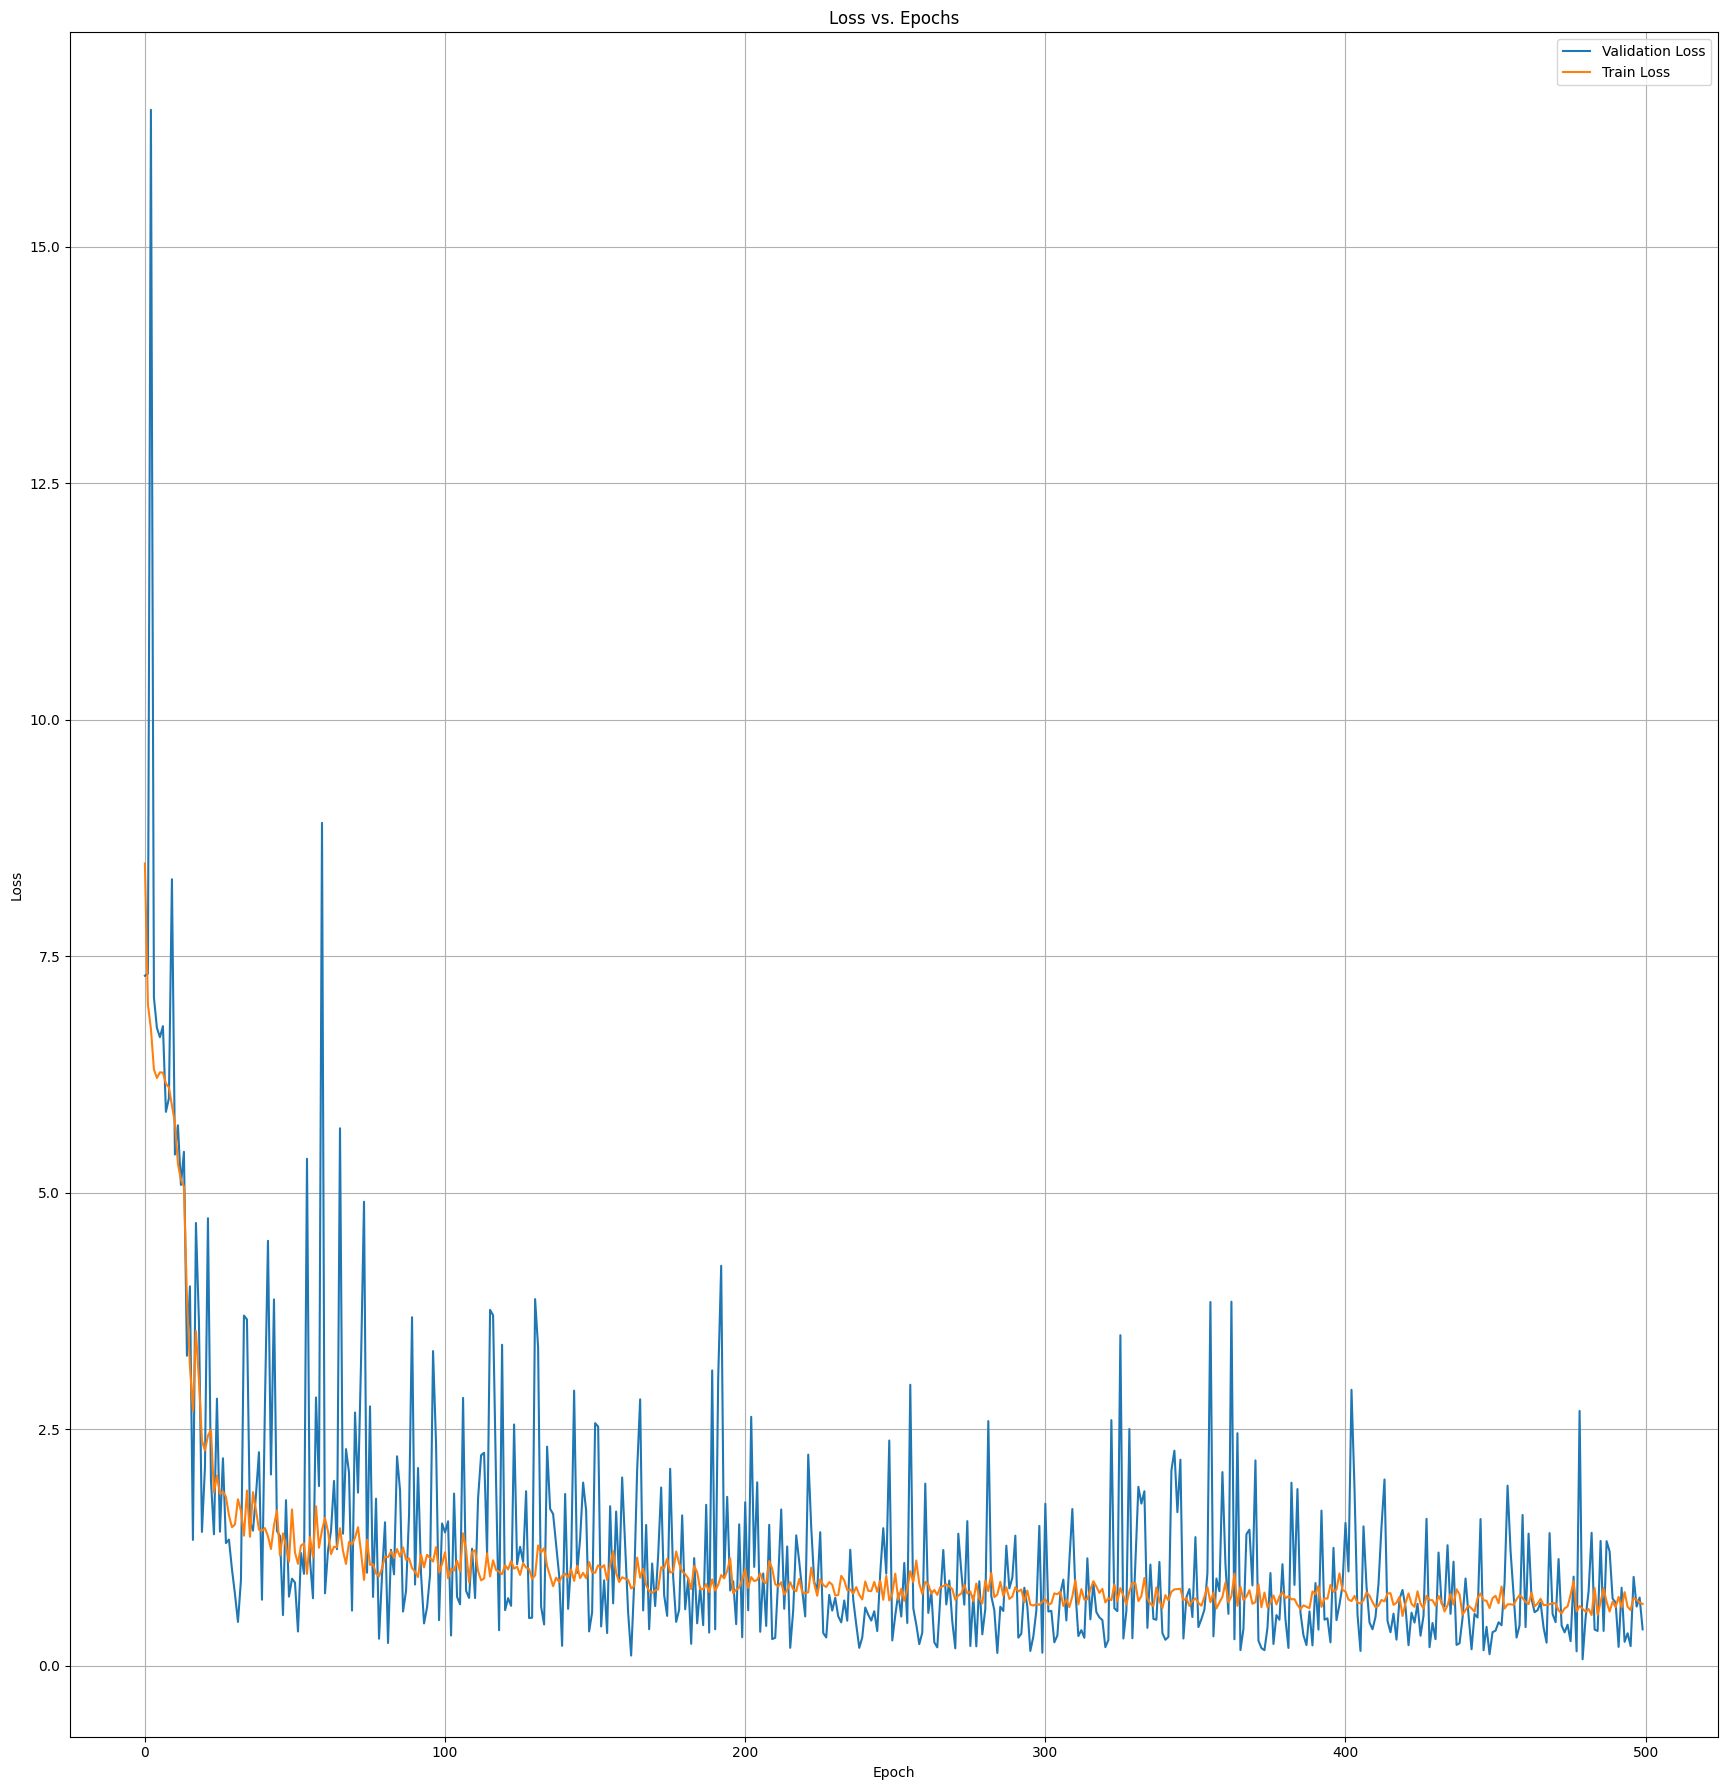

In [31]:
# Buat grafik Loss
plt.figure(figsize=(34, 18))
plt.subplot(1, 2, 2)
plt.plot(trained_data.history['val_loss'], label='Validation Loss')
plt.plot(trained_data.history['loss'], label='Train Loss')
plt.title('Loss vs. Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()